<a href="https://colab.research.google.com/github/Jaewon45/ESAA_2022/blob/main/1114_RecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/saurav9786/recommender-system-using-amazon-reviews#Analyzing-the-rating

# Introduction to Recommendation systems

# Types of recommendations

- Popularity based systems : items viewed and purchased by most people and are rated high
- Classification model based: classification algorithm to decide whether the user is interested or not in the product
- Content based recommedations: information on the contents of the item, recommending similar item
- Collaberative Filtering: things that are liked by other people with similar taste. it is mainly of two types: a) User-User b) Item -Item
- Hybrid Approaches: collaborative filtering, content-based filtering, and other approaches 
- Association rule mining : relationships between items based on their patterns of co-occurrence across transactions

# Attribute Information

- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user
- timestamp : Time of the rating (무시)

# Import Libraries

In [5]:
import numpy as np 
import pandas as pd 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

# Load the Dataset and Add headers

In [6]:
electronics_data = pd.read_csv('/content/ratings_Electronics (1).csv',names=['userId', 'productId','Rating','timestamp'])

In [7]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [8]:
electronics_data.shape

(412319, 4)

# EDA

In [10]:
# subset 생성
electronics_data=electronics_data.iloc[:1048576,0:]

In [11]:
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp    float64
dtype: object

In [12]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412319 entries, 0 to 412318
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     412319 non-null  object 
 1   productId  412319 non-null  object 
 2   Rating     412318 non-null  float64
 3   timestamp  412318 non-null  float64
dtypes: float64(2), object(2)
memory usage: 12.6+ MB


In [13]:
electronics_data.describe()['Rating'].T

count    412318.000000
mean          3.977893
std           1.395982
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [14]:
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [15]:
# Handling Missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       1
timestamp    1
dtype: int64


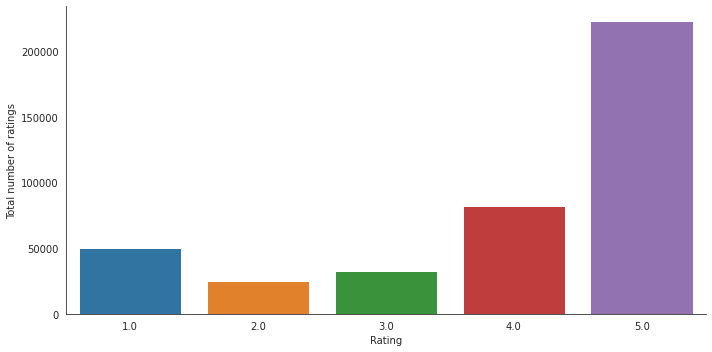

In [16]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

- 대부분 5점을 준 경우가 많음

In [17]:
# Unique Users and products
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 412319
Total No of Users   : 337931
Total No of products  : 25683


In [18]:
#Dropping the Timestamp column
electronics_data.drop(['timestamp'], axis=1,inplace=True)

In [19]:
#Analysis of rating given by the user 
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     263
A231WM2Z2JL0U3    245
A25HBO5V8S8SEA    149
AKT8TGIT6VVZ5      80
A2AEZQ3DGBBLPR     74
Name: Rating, dtype: int64

In [20]:
no_of_rated_products_per_user.describe()

count    337931.000000
mean          1.220125
std           1.173899
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         263.000000
Name: Rating, dtype: float64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

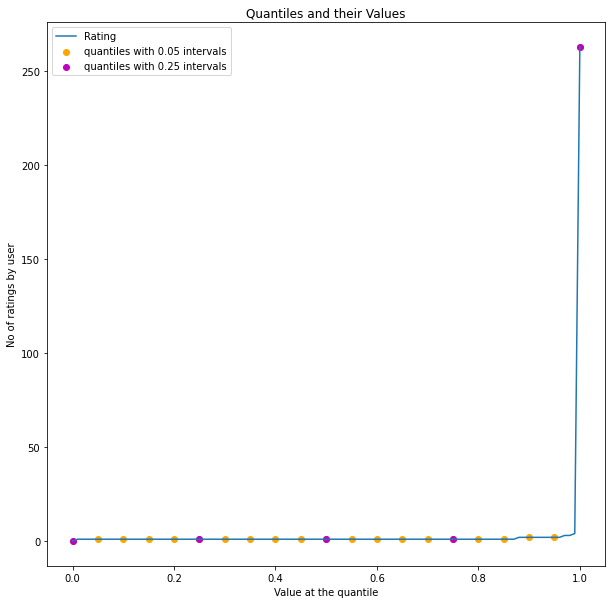

In [21]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [22]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 18



# Popularity Based Recommendation

In [23]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

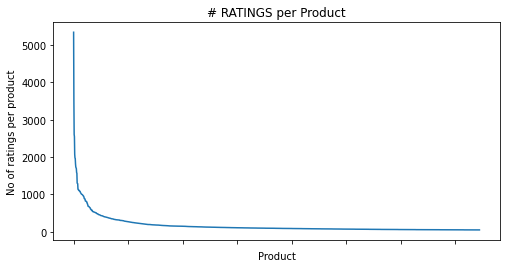

In [24]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [25]:
#Average rating of the product 
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [26]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B00006I53W    4.859551
Name: Rating, dtype: float64

In [27]:
#Total no of rating for product
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0001FTVEK    5345
B00007E7JU    3523
B00007M1TZ    2608
B00004ZCJE    2547
B00001P4ZH    2075
Name: Rating, dtype: int64

In [28]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [30]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [31]:
ratings_mean_count['rating_counts'].max()

5345

<Figure size 576x432 with 0 Axes>

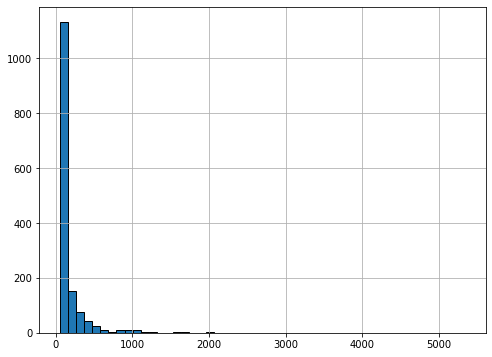

In [32]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

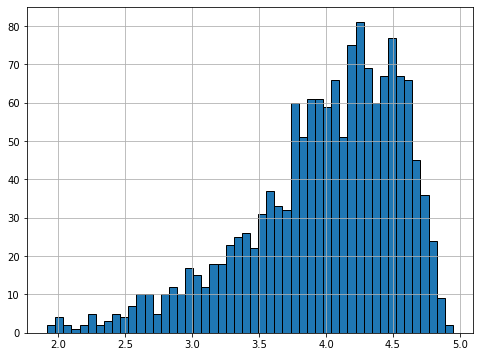

In [33]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

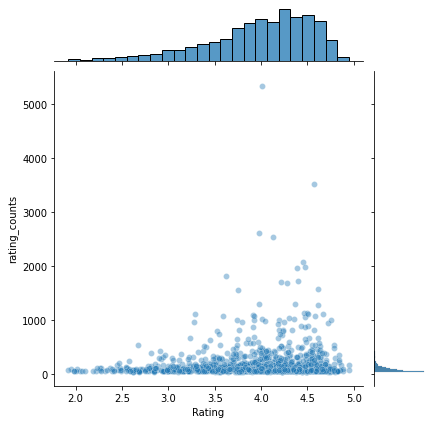

In [34]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

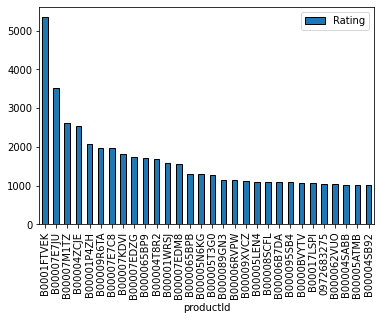

In [35]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

- 단순히 rating이 높은 상품기반으로 신규 고객에게 추천 (customized가 아님)

# Collaberative filtering (Item-Item recommedation)

- collaborative filtering (CF) approach : based on the idea that the best recommendations come from people who have similar tastes

In [37]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633997 sha256=0fb338613b60996d0e598771dc9b8441dbfa4abb1cf24922e1aaf6b12745dc05
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [38]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [39]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [40]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

# run the trained model against the testset
test_pred = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [42]:
test_pred

[Prediction(uid='A1RV8BNE37L0CE', iid='B00005B6TI', r_ui=4.0, est=4.054844983921575, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A16N6SUZ6BJPUL', iid='B00007M1TZ', r_ui=3.0, est=4.054844983921575, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A2802HG1Y0BGU6', iid='B000095SB6', r_ui=2.0, est=4.054844983921575, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3PZDYFXKX3FS9', iid='B0001VGFKW', r_ui=5.0, est=4.054844983921575, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1LFQ1S2VG7F3Y', iid='B000062VUO', r_ui=5.0, est=4.054844983921575, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1QZSV9MZLZYJV', iid='B00007IFED', r_ui=5.0, est=4.054844983921575, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A15TDN3RT50

In [43]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3422


1.3422263518176782

# Model-based collaborative filtering system

In [44]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

# sparse matrix

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
ratings_matrix.shape

(9832, 76)

In [46]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
X.shape

(76, 9832)

In [49]:
X1 = X
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [50]:
#Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [51]:
X.index[75]

'B00000K135'

In [55]:
pd.DataFrame(correlation_matrix)

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,1.000000,-0.114588,-0.154682,-0.155324,-0.144872,-0.087231,-0.128290,-0.170569,-0.161714,-0.242035,...,0.101377,-0.013738,-0.110502,-0.107193,0.209177,-0.045206,-0.205353,0.198052,0.195763,-0.056736
1,-0.114588,1.000000,0.979681,0.988115,-0.417717,-0.083814,-0.118137,0.818743,0.921859,0.916262,...,-0.096580,0.633181,-0.114106,0.616966,-0.673101,-0.826425,0.771550,-0.356382,-0.401895,-0.621624
2,-0.154682,0.979681,1.000000,0.986298,-0.305766,-0.098640,0.071100,0.907475,0.886601,0.936748,...,-0.137050,0.583608,-0.147988,0.569106,-0.620984,-0.827048,0.714069,-0.316409,-0.360401,-0.632348
3,-0.155324,0.988115,0.986298,1.000000,-0.308396,0.023615,-0.038913,0.850147,0.946681,0.945534,...,-0.135967,0.598777,-0.152846,0.615758,-0.665091,-0.819529,0.737665,-0.354856,-0.406684,-0.610324
4,-0.144872,-0.417717,-0.305766,-0.308396,1.000000,0.320404,0.660183,-0.007580,-0.187745,-0.072627,...,0.021814,-0.198777,-0.170733,0.131748,0.084869,0.419086,-0.375002,-0.073424,-0.085197,0.508448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.045206,-0.826425,-0.827048,-0.819529,0.419086,-0.046563,-0.020972,-0.766290,-0.692920,-0.708951,...,-0.000777,-0.641452,0.359181,-0.265426,0.221113,1.000000,-0.609951,-0.142779,-0.084047,0.869808
72,-0.205353,0.771550,0.714069,0.737665,-0.375002,-0.150786,-0.262859,0.539876,0.734658,0.804759,...,0.186904,0.714240,-0.267238,0.685004,-0.691228,-0.609951,1.000000,-0.413605,-0.433156,-0.244931
73,0.198052,-0.356382,-0.316409,-0.354856,-0.073424,0.223758,0.258233,-0.129404,-0.483403,-0.462190,...,0.400574,0.059162,0.102385,-0.779537,0.917020,-0.142779,-0.413605,1.000000,0.992984,-0.461716
74,0.195763,-0.401895,-0.360401,-0.406684,-0.085197,0.161210,0.261913,-0.166982,-0.546855,-0.508819,...,0.424112,0.023191,0.139243,-0.812026,0.935152,-0.084047,-0.433156,0.992984,1.000000,-0.408680


In [52]:
# productID를 corr matrix 인덱스로 변경
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [53]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

- 상관성 높은 상품 top 25개까지 추천

In [57]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 
Recommend

['3744295508',
 '9573212919',
 '9983891212',
 'B000001ON6',
 'B00000J1QK',
 'B00000J1SC',
 'B00000J1TX',
 'B00000J1U8',
 'B00000JBAT',
 'B00000JCT8',
 'B00000JCTO',
 'B00000JFE3',
 'B00000JPPI']